# Lab 3 - Filter banks

Explore the design of filter banks, first designing the bandpass filters and building a filter bank structure that is able to obtain a perfect reconstruction of a sound.

## References:

### Low-pass filter
A low-pass filter is a filter that passes signal components with frequencies lower than a selected cutoff frequency and attenuates signal components with frequencies higher than the cutoff frequency.

### firwin
Algorithm in `scipy.signal`to perform an FIR filter design using the window method. This involves designing an ideal filter in the frequency domain and then applying a window function to smooth the frequency response and limit the number of taps (filter order).

### Bandpass filter
A band-pass filter is a filter that passes frequencies within a certain range and rejects (attenuates) frequencies outside that range. It's the opposite of a band-stop filter.

### Impulse response of a filter
A filter's impulse response function is simply the output of the filter when the input is an impulse of amplitude 1 at time zero.

### Frequency response of a filter
The frequency response of a filter is computed by taking the Fourier Transform of the impulse response and tells us how the filter affects the magnitudes and phases of the frequencies of a signal.

### Filter bank structure
An array of bandpass filters that separates the input signal into multiple components, each one carrying a sub-band of the original signal.

### Perfect reconstruction
Coding/decoding with which we recover the origianl sound identically.

### Critical sampling
In audio coding, critical sampling means that the encoding representation is of the same size than the original signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.fft import fft
from scipy import signal as signal

In [2]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

def prototype_filter(N, L):
  """ Generate a prototype FIR low-pass filter using a window method.
    Args:
      N (int): length of filter
      L (int): number of subbands
    Returns:
      Coefficients of the resulting FIR filter
  """
  return signal.firwin(N, 1.0 / (2 * L), window='hamming')

def modulate_filter(h, M, k):
    # Modulate the prototype filter
    n = np.arange(len(h))
    modulation = 2 * np.cos(np.pi * (2 * k + 1) * (n - (len(h) - 1) / 2) / (2 * M))
    return h * modulation

def analysis_filter_bank(x, M, N):
    # Analysis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    subband_length = len(x) // M
    subbands = np.zeros((M, subband_length))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        filtered_signal = signal.lfilter(hk, 1.0, x)
        # Ensure the subband length matches the expected size
        downsampled_signal = filtered_signal[::M]
        if len(downsampled_signal) > subband_length:
            subbands[k] = downsampled_signal[:subband_length]
        else:
            subbands[k, :len(downsampled_signal)] = downsampled_signal

    return subbands

def synthesis_filter_bank(subbands, M, N):
    # Synthesis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    y_reconstructed = np.zeros(M * len(subbands[0]))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        upsampled_signal = np.zeros(len(y_reconstructed))
        upsampled_signal[::M] = subbands[k]  # Upsample by M
        y_reconstructed += signal.lfilter(hk, 1.0, upsampled_signal)

    return y_reconstructed

## Part 1 - Low-pass filtering

Design a low-pass filter using the window method, `firwin` algorithm, and filter a sound with it. Answer the questions given and modify the code to support your answers.

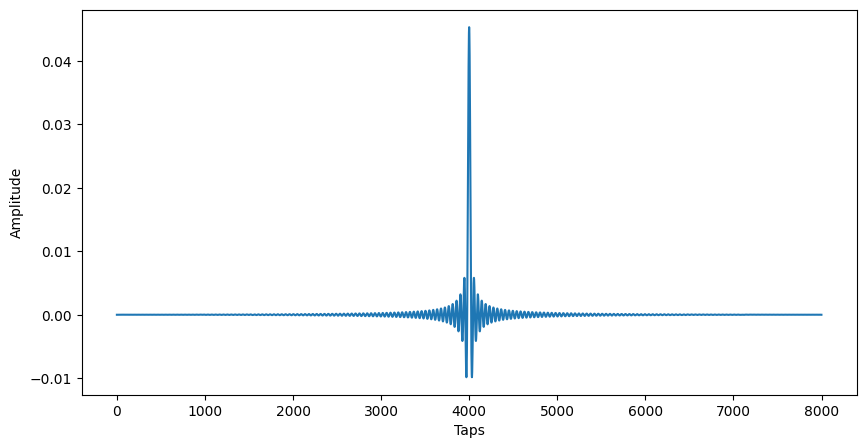

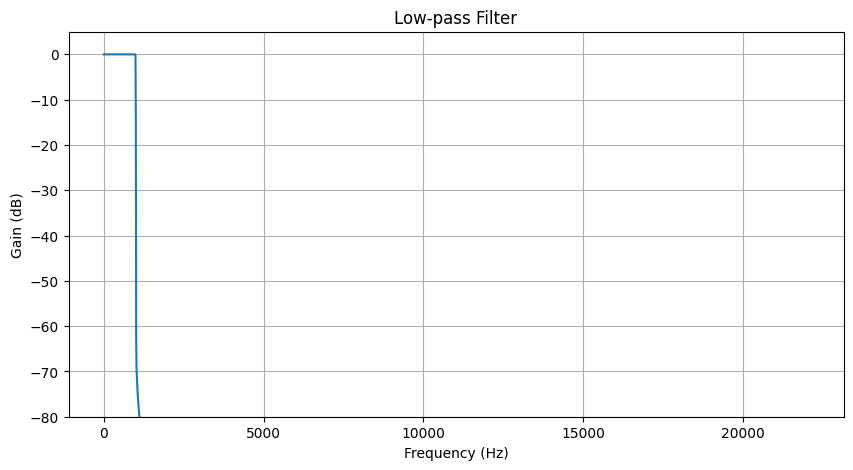

In [3]:
# design a low pass filter
fs = 44100.0
filter_length = 8000
cutoff = 1000
h = signal.firwin(filter_length, cutoff, window='hamming', fs=fs)

# plot impulse response of filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.show()

# plot frequency response of filter
w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Low-pass Filter")
plt.show()

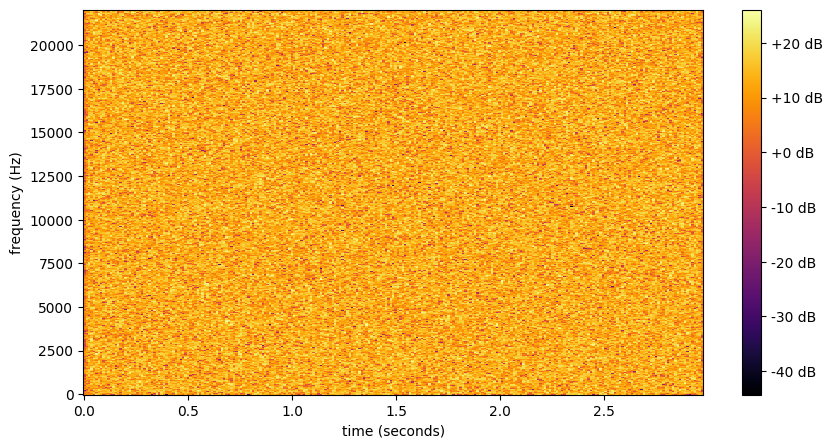

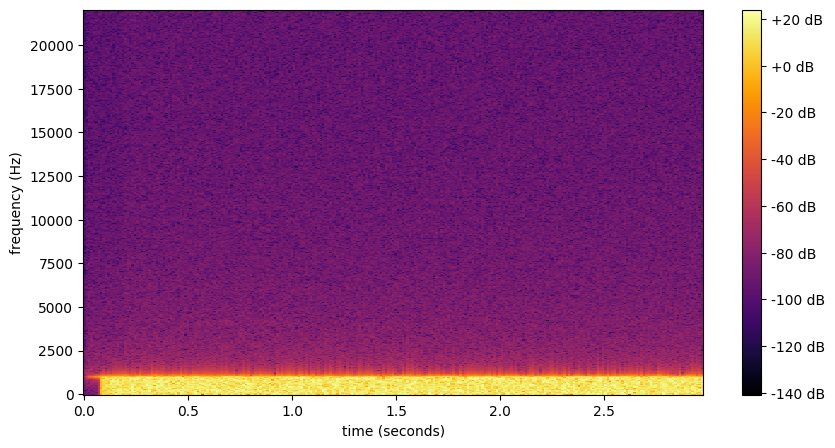

In [4]:
# filter a sound with the lowpass filter
sound_array, sampling_rate = read_sound('../sounds/white-noise.wav')
# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(h, 1, sound_array)
# display original sound
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)

**Questions:**

1. Design a lowpass filter with cutoff frequency of 2000Hz, using the `firwin` algorithm with different values for filter-length. Try values of 8, 800, 8000. Show the frequency responses and explain the differences.

In this exercice we design a low-pass filter using the window method, `firwin` algorithm, and filter a sound with it. This algorithm uses the window method. This involves designing an ideal filter in the frequency domain and then applying a window function to smooth the frequency response and limit the number of taps (filter order).

For the first filter-length we have 8. At this small filter length, the filter resembles a triangle in the time domain  The filter does not sharply cut off the frequencies above the desired cutoff point of 2000 Hz. As a result, we observe that some mid and high frequencies still pass through, and the cutoff is not well defined. This in the frequency it shows that we have low and mid frequencys, but at 15000Hz we dont have sound.

With a filter length of 800, the response becomes much smoother, and the filter behaves like a more typical low-pass filter. It effectively attenuates frequencies above 2000 Hz.

The filter with a length of 8000 provides also the cutoff, but we see a small delay at the beginning of the sound.

2. Filter the sound `white-noise.wav` with the filters designed in question 1. Listen and explain the results, supporting it by showing the spectrograms of the filtered sounds.

For the filter length of 8, the sound is similar to the original but quieter. For the filter length of 800, the sound is attenuated, as we can also see in the spectrogram. Finally, for the filter length of 8000, the sound starts later, as there is no sound at the beginning, and then it becomes slightly more attenuated than with the filter length of 800.

---

## Part 2 - Bank of bandpass filters

Design a bank of band-pass filters and apply it to a sound. Answer the questions given and modify the code to support your answers.

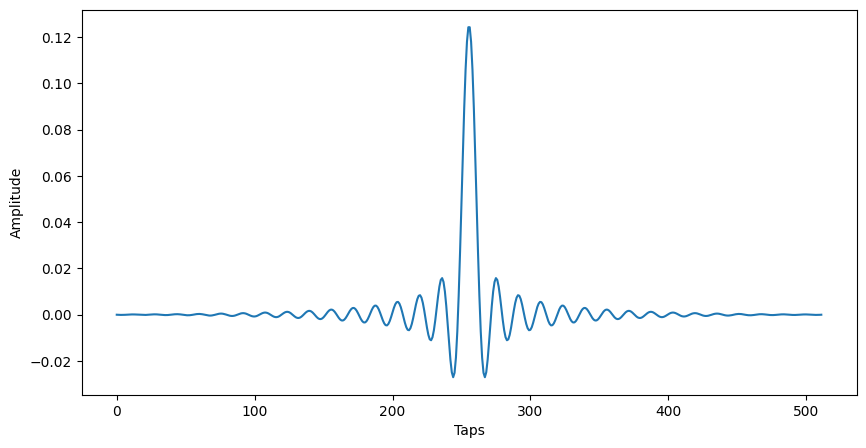

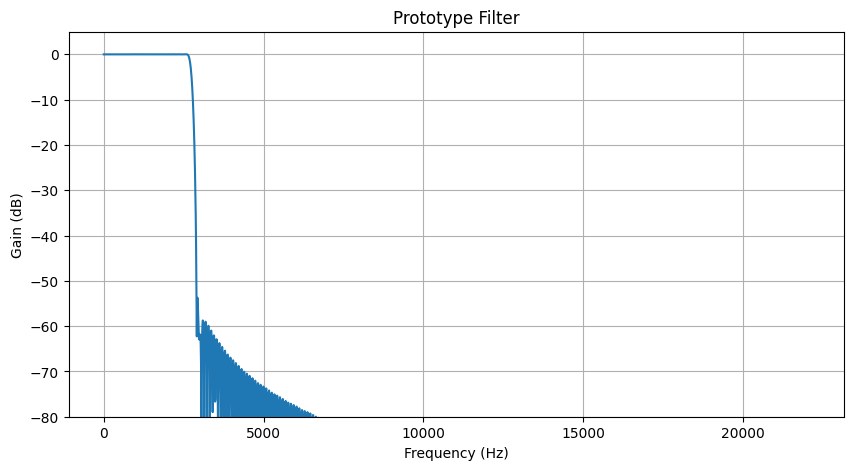

<Figure size 1000x500 with 0 Axes>

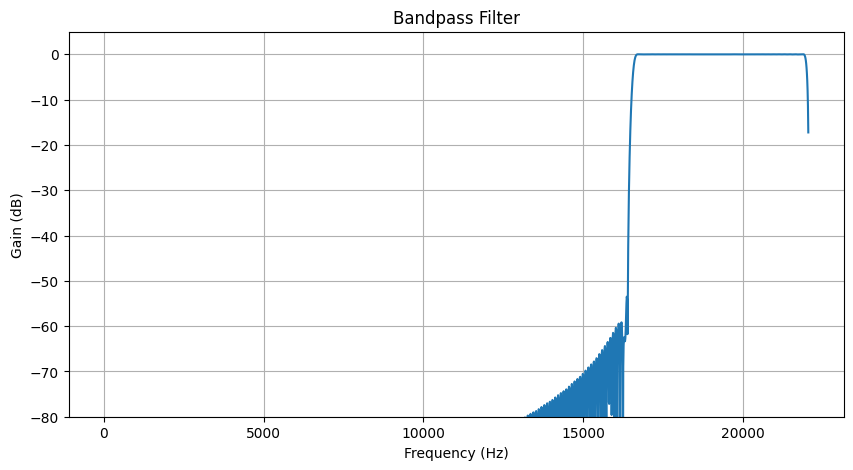

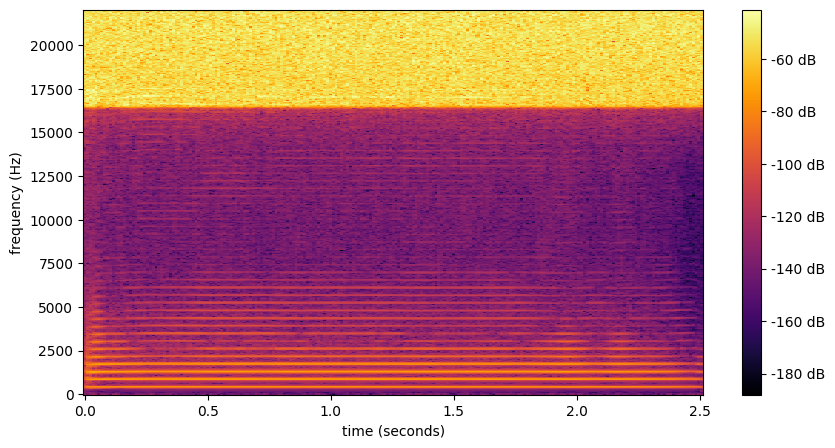

In [5]:
# Parameters for the filter bank
N = 512  # Length of the prototype filter
L = 4   # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# Plot the prototype filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')

w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Prototype Filter")
plt.show()

# Create a bandpass filter
k = 3  # index of a band pass filter
hk = modulate_filter(h, L, k)

plt.figure(figsize=(10, 5))
w, H = signal.freqz(hk, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Bandpass Filter")
plt.show()

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')
# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(hk, 1, sound_array)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)


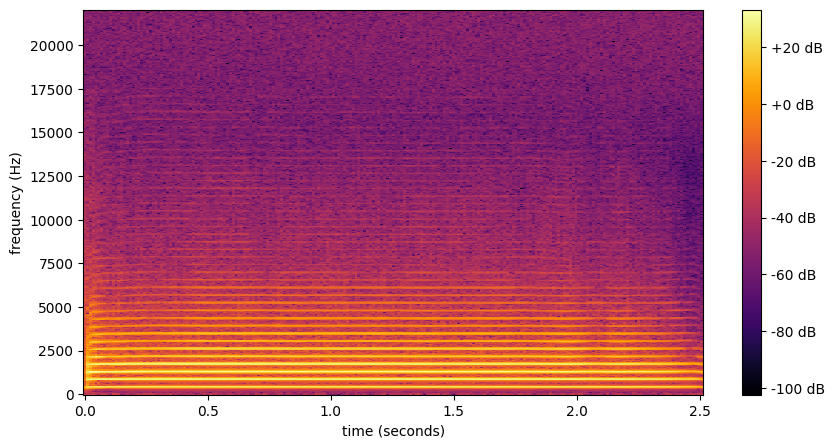

In [6]:
y = np.zeros(len(sound_array))

# apply the whole filter bank to a sound
for k in range(L):
  # Modulate prototype filter
  hk = modulate_filter(h, L, k)
  # Filter the signal
  filtered_sound = signal.lfilter(hk, 1, sound_array)
  y += filtered_sound

# display filtered sound
ipd.display(ipd.Audio(data=y, rate=sampling_rate))
display_spectrogram(y, 512, 1024, sampling_rate)

**Questions**
1. Implement a low-pass filter and convert it to a band-pass filter. Explain how it works. Implement one example of a bandpass filter (define your own variables) and explain the result obtained when applying it to a particular sound (use one of the sounds in the sound directory).

A band-pass filter allows frequencies within a specific range (band) to pass while attenuating frequencies outside that range. To convert a low-pass filter into a band-pass filter, the low-pass filter is modulated, effectively shifting its frequency response to a desired frequency band.

By varying the parameter k, we can adjust the center frequency of the band-pass filter. For larger values of k, the filter shifts towards higher frequencies, often making the sound unrecognizable due to the higher frequency content. For smaller values of k, the filter behaves more like a low-frequency filter, allowing you to hear lower-frequency components of the sound more clearly. For example, with a lower k, the trumpet sound becomes more distinct as it focuses on the low-frequency portion of the signal.

2. Implement a complete filter bank, apply it to the sound chosen in question 1 and try to get the best reconstruction by changing the size of the filters, N, and the number of filters, L. Explain the result.

The quality of reconstruction depends on two main parameters: the filter size N (which controls the length of the filter) and the number of subbands L (which defines how many frequency bands the sound is split into).

I set N = 512 for the length of the prototype filter and L = 4 for the number of subbands. These values offer a balance between computational efficiency and frequency resolution. With a filter length N = 512, the filter is able to capture enough and setting L = 4 divides the frequency range into 4 subbands, giving good frequency separation.

---

## Part 3 - Critical sampling
Experiment with critical sampling (the bandpass signals ocupy the same memory than the original signal), choosing the value L as the number of subbands, then downsampling each filtered band by L and finally upsampling them by L at the reconstruction stage.

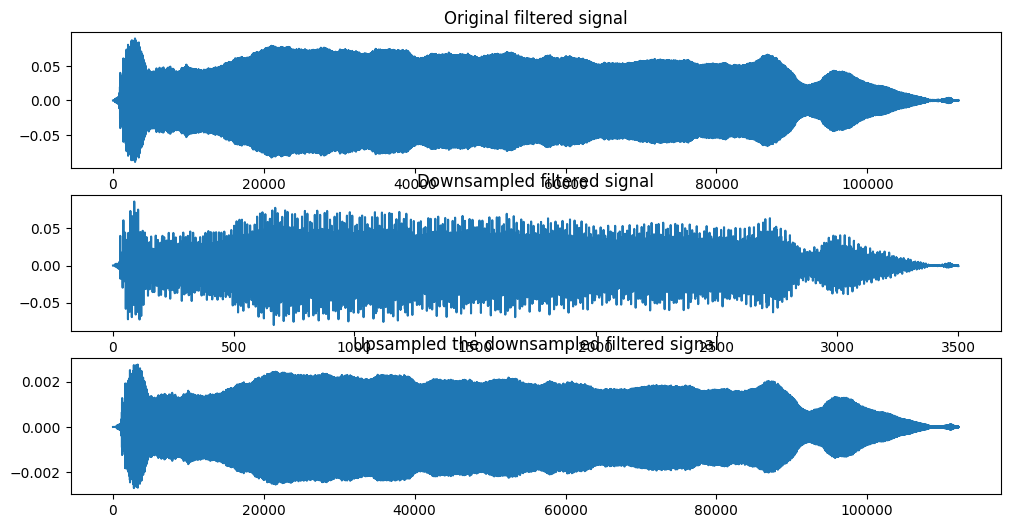

In [7]:
# downsample and upsample a filtered signal

# Parameters for the filter bank
N = 512  # Length of the prototype filter
L = 32   # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# generate bandpass filter
k = 3
hk = modulate_filter(h, L, k)

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')

# Filter the signal
y = signal.lfilter(hk, 1.0, sound_array)
# down-sample the filtered signal
yd = y[::L]

# Upsample
yu = np.zeros(len(yd) * L)
yu[::L] = yd
# Filter with same filter than in encoding
yu = signal.lfilter(hk, 1.0, yu)

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title("Original filtered signal")
ipd.display(ipd.Audio(data=y, rate=sampling_rate))

plt.subplot(3, 1, 2)
plt.plot(yd)
plt.title("Downsampled filtered signal")
ipd.display(ipd.Audio(data=yd, rate=sampling_rate/L))

plt.subplot(3, 1, 3)
plt.plot(yu)
plt.title("Upsampled the downsampled filtered signal")
ipd.display(ipd.Audio(data=yu, rate=sampling_rate))
plt.show()

Original Input Signal Size: 112076
Total Size of Subbands: 112070


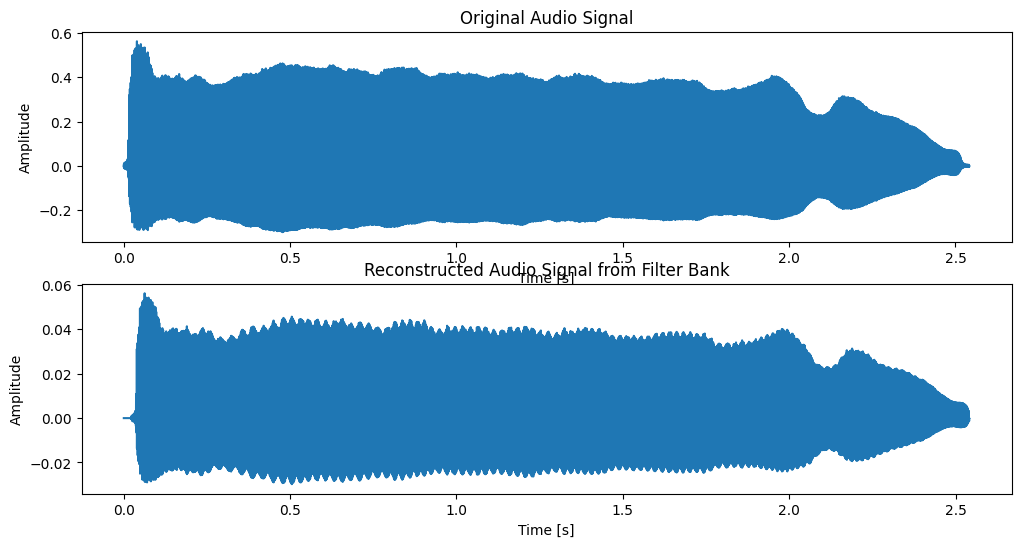

In [8]:
# encode and decode a signal with an bank of filters

# Parameters for the filter bank
N = 1024  # Length of the prototype filter
L = 10   # Number of subbands
fs = 44100  # Sampling rate

sound_array, sampling_rate = read_sound('../sounds/487465-trumpet.wav')
t = np.linspace(0, len(sound_array)/sampling_rate, len(sound_array), endpoint=False)

# Analysis (encoding): split the signal into subbands
subbands = analysis_filter_bank(sound_array, L, N)

#Size of the input signal
input_size = len(sound_array)
print(f"Original Input Signal Size: {input_size}")

# Size of all subbands after downsampling
total_subband_size = sum(len(subband) for subband in subbands)
print(f"Total Size of Subbands: {total_subband_size}")

# Synthesis (decoding): reconstruct the signal from subbands
reconstructed_signal = synthesis_filter_bank(subbands, L, N)

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sound_array)
plt.title("Original Audio Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

plt.subplot(2, 1, 2)
plt.plot(t[:len(reconstructed_signal)],reconstructed_signal)
plt.title("Reconstructed Audio Signal from Filter Bank")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=reconstructed_signal, rate=sampling_rate))

plt.show()

**Questions:**

1. Create a filter bank for L number of subbands. Apply it to a sound from the sounds directory while downsampling by L the subbands (encoded signal), then upsampling the subbands and addindg them together (decoded signal). Try to get the best reconstruction by trying different filter lengths (ex: 64, 128, 256). Explain the result.

For filter lengths of 32 and 64, the reconstruction is very close to the original sound, with minimal distortion. As we increase the filter length to 128, we start to hear some distortion, but it is still relatively clear. However, when we use a filter length of 256, noticeable aliasing occurs due to the downsampling. This causes the reconstruction to sound quite different from the original, with distinct artifacts and a less accurate reproduction of the sound.

After testing various lengths, I chose a filter length of 64 because it provides a reconstruction that closely resembles the original sound without significant distortion or aliasing.

2. Prove that the encoding process performs critical sampling, so the size of all the subbands (the encoded matrix) is equal to the size of the input signal. Add the needed code.

To prove critical sampling, I check whether the total size of the downsampled subbands is the same as the size of the original input signal. In this case, the size of the input signal is 112076, and the total size of the subbands after downsampling is 112070. The small difference between these sizes is probabily due to the filtering process.

---